In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import sys  
sys.path.insert(0, '../../')
import RadonDF_Handler

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [28]:
def df_to_X_y(df,hoursToPredict, window_size):
        hoursToPredict = hoursToPredict - 1
        df_as_np = df.to_numpy() # converts the dataframe to a numpy array
        #Initialized  arrays to append X and Y values 
        X = []
        y = []
        for i in range(len(df_as_np)):
            if((i + hoursToPredict + window_size)< len(df_as_np)):
                #Takes values from i to i + win size
                row =  [r for r in df_as_np[i:i+window_size]]
                X.append(row)
                label = df_as_np[i + hoursToPredict + window_size ][0]
                y.append(label)
        return np.array(X), np.array(y)

In [29]:
def DataHandler(hoursToPredict,window_size):
    D001_df = pd.read_csv('./../../../../../Data/SensorsData/interpolated_D001_data.csv')
    D001_df = pd.DataFrame(D001_df)
    D001_df['time'] =  pd.to_datetime(D001_df['time'], format='%Y-%m-%d %H:%M:%S')
    D001_df.index = D001_df['time']
    D001_df = D001_df.drop(['time'],axis = 1)
    
    X1, y1 = df_to_X_y(D001_df,hoursToPredict,window_size)

    return X1, y1

In [30]:
plt.style.use('seaborn')

In [31]:
def Trainer(time):
    window_size =  6
    while(window_size <= 12):
        model = Sequential()
        model.add(InputLayer((window_size, 5)))
        model.add(LSTM(64))
        model.add(Dense(8, 'relu'))
        model.add(Dense(1, 'linear'))

        model.summary()
        X, y = DataHandler(time,window_size)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
        
#         X_train, y_train = X[:92508], y[:92508] # training data
#         X_val, y_val = X[92508:95508], y[92508:95508] #validation
#         X_test, y_test = X[95508:], y[95508:] #test
        X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
        
        cp1= ModelCheckpoint(str(time)+"H_ForecastModel_"+str(window_size)+"_SizeWindow/", save_best_only=True)
        model.compile(loss=MeanSquaredError(), 
                   optimizer=Adam(learning_rate=0.0001), 
                   metrics=[MeanAbsoluteError()])
    
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, callbacks=[cp1])
        window_size += 1
        print()
        print("-----------------------------------------------------------------------------------------------------------")
        print()

    window_size = 6 #reset

In [35]:
def modelsEvaluator(time,startWindow,endWindow,jumpOneWindow):
    while(startWindow <= endWindow):
        X, y = DataHandler(time,startWindow)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
#         X_train, y_train = X[:92508], y[:92508] # training data
#         X_val, y_val = X[92508:95508], y[92508:95508] #validation
#         X_test, y_test = X[95508:], y[95508:] #test
        print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
       
        print("Loading: "+ str(time)+"H_ForecastModel_"+str(startWindow)+"_SizeWindow/")
        model = load_model(str(time)+"H_ForecastModel_"+str(startWindow)+"_SizeWindow/")
        model.evaluate(X_test,y_test)
        
        test_predictions = model.predict(X_test).flatten()
        test_results = pd.DataFrame(data={'Test Predictions '+str(time) + ' hour model':test_predictions, 'Actuals':y_test})
        
        print('\n')
        if(jumpOneWindow):
            startWindow += 2
        else:
            startWindow += 1

In [33]:
%%time

Trainer(1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
178/178 [==============================] - 5s 13ms/step - loss: 461.0031 - mean_absolute_error: 20.8548 - val_loss: 441.8065 - val_mean_absolute_error: 20.3674
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
178/178 [==============================] - 1s 7ms/step - loss: 388.4973 - mean_absolute_error: 19.0058 - val_loss: 348.0309 - val_mean_absolute_error: 17.8630
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
178/178 [==============================] - 1s 7ms/step - loss: 279.2208 - mean_absolute_error: 15.7878 - val_loss: 229.6531 - val_mean_absolute_error: 14.0390
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
178/178 [==============================] - 1s 7ms/step - loss: 173.5164 - mean_absolute_error: 11.8310 - val_loss: 139.0153 - val_mean_absolute_error: 10.1544
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
178/178 [==============================] - 1s 8ms/step - loss: 104.4727 - mean_absolute_error: 8.2692 - val_loss: 88.8649 - val_mean_absolute_error: 7.0521
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
178/178 [==============================] - 1s 7ms/step - loss: 69.1089 - mean_absolute_error: 5.7796 - val_loss: 63.6805 - val_mean_absolute_error: 5.2292
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
178/178 [==============================] - 1s 7ms/step - loss: 53.3275 - mean_absolute_error: 4.6071 - val_loss: 53.4524 - val_mean_absolute_error: 4.5732
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 8/25
178/178 [==============================] - 1s 8ms/step - loss: 45.1468 - mean_absolute_error: 4.1914 - val_loss: 46.5514 - val_mean_absolute_error: 4.3017
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 9/25
178/178 [==============================] - 1s 7ms/step - loss: 41.2548 - mean_absolute_error: 4.1088 - val_loss: 43.5261 - val_mean_absolute_error: 4.2628
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 10/25
178/178 [==============================] - 1s 6ms/step - loss: 39.2331 - mean_absolute_error: 4.0849 - val_loss: 39.9179 - val_mean_absolute_error: 4.1130
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 11/25
178/178 [==============================] - 1s 8ms/step - loss: 35.4476 - mean_absolute_error: 3.8729 - val_loss: 37.1227 - val_mean_absolute_error: 3.9643
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 12/25
178/178 [==============================] - 2s 12ms/step - loss: 33.5346 - mean_absolute_error: 3.7941 - val_loss: 35.1152 - val_mean_absolute_error: 3.8661
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 13/25
178/178 [==============================] - 4s 21ms/step - loss: 31.4204 - mean_absolute_error: 3.6536 - val_loss: 32.6816 - val_mean_absolute_error: 3.7416
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 14/25
178/178 [==============================] - 2s 11ms/step - loss: 29.3271 - mean_absolute_error: 3.5534 - val_loss: 30.6448 - val_mean_absolute_error: 3.6526
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 15/25
178/178 [==============================] - 2s 11ms/step - loss: 27.6255 - mean_absolute_error: 3.4736 - val_loss: 28.5402 - val_mean_absolute_error: 3.5111
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 16/25
178/178 [==============================] - 1s 8ms/step - loss: 25.7664 - mean_absolute_error: 3.3550 - val_loss: 26.7974 - val_mean_absolute_error: 3.4330
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 17/25
178/178 [==============================] - 1s 7ms/step - loss: 23.4051 - mean_absolute_error: 3.2139 - val_loss: 23.6840 - val_mean_absolute_error: 3.2482
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 18/25
178/178 [==============================] - 1s 8ms/step - loss: 21.2406 - mean_absolute_error: 3.0895 - val_loss: 21.7607 - val_mean_absolute_error: 3.1527
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 19/25
178/178 [==============================] - 1s 7ms/step - loss: 19.6182 - mean_absolute_error: 3.0057 - val_loss: 20.1105 - val_mean_absolute_error: 3.0611
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 20/25
178/178 [==============================] - 1s 7ms/step - loss: 18.1030 - mean_absolute_error: 2.9130 - val_loss: 18.1686 - val_mean_absolute_error: 2.8769
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 21/25
178/178 [==============================] - 1s 7ms/step - loss: 15.4208 - mean_absolute_error: 2.6151 - val_loss: 15.3120 - val_mean_absolute_error: 2.6461
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 22/25
178/178 [==============================] - 1s 7ms/step - loss: 13.7057 - mean_absolute_error: 2.4926 - val_loss: 13.7091 - val_mean_absolute_error: 2.5200
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 23/25
178/178 [==============================] - 2s 10ms/step - loss: 12.1393 - mean_absolute_error: 2.3253 - val_loss: 11.9682 - val_mean_absolute_error: 2.2981
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 24/25
178/178 [==============================] - 1s 8ms/step - loss: 9.6464 - mean_absolute_error: 2.0619 - val_loss: 9.0109 - val_mean_absolute_error: 2.0098
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 25/25
178/178 [==============================] - 1s 7ms/step - loss: 8.1534 - mean_absolute_error: 1.9055 - val_loss: 8.4210 - val_mean_absolute_error: 1.9937
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
178/178 [==============================] - 5s 14ms/step - loss: 444.0955 - mean_absolute_error: 20.3962 - val_loss: 403.7365 - val_mean_absolute_error: 19.3537
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
178/178 [==============================] - 1s 8ms/step - loss: 340.4170 - mean_absolute_error: 17.6247 - val_loss: 267.4940 - val_mean_absolute_error: 15.3671
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
178/178 [==============================] - 2s 10ms/step - loss: 186.4137 - mean_absolute_error: 12.2421 - val_loss: 132.1300 - val_mean_absolute_error: 9.5724
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
178/178 [==============================] - 2s 12ms/step - loss: 95.2775 - mean_absolute_error: 7.3598 - val_loss: 76.5091 - val_mean_absolute_error: 5.9021
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
178/178 [==============================] - 1s 8ms/step - loss: 62.0079 - mean_absolute_error: 5.0348 - val_loss: 55.1573 - val_mean_absolute_error: 4.6135
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 6/25
178/178 [==============================] - 2s 10ms/step - loss: 48.4173 - mean_absolute_error: 4.2890 - val_loss: 47.4291 - val_mean_absolute_error: 4.2348
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 7/25
178/178 [==============================] - 1s 8ms/step - loss: 42.9912 - mean_absolute_error: 4.0319 - val_loss: 41.8097 - val_mean_absolute_error: 3.9962
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 8/25
178/178 [==============================] - 1s 8ms/step - loss: 38.0184 - mean_absolute_error: 3.8443 - val_loss: 36.9184 - val_mean_absolute_error: 3.8079
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 9/25
178/178 [==============================] - 1s 8ms/step - loss: 33.6927 - mean_absolute_error: 3.6433 - val_loss: 33.5590 - val_mean_absolute_error: 3.6106
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 10/25
178/178 [==============================] - 2s 9ms/step - loss: 30.9933 - mean_absolute_error: 3.5219 - val_loss: 30.8893 - val_mean_absolute_error: 3.5137
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 11/25
178/178 [==============================] - 2s 11ms/step - loss: 28.6517 - mean_absolute_error: 3.4293 - val_loss: 28.4804 - val_mean_absolute_error: 3.4419
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 12/25
178/178 [==============================] - 2s 10ms/step - loss: 26.0563 - mean_absolute_error: 3.3124 - val_loss: 26.0575 - val_mean_absolute_error: 3.3230
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 13/25
178/178 [==============================] - 1s 8ms/step - loss: 24.0107 - mean_absolute_error: 3.1942 - val_loss: 24.0677 - val_mean_absolute_error: 3.2108
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 14/25
178/178 [==============================] - 1s 8ms/step - loss: 22.0195 - mean_absolute_error: 3.0806 - val_loss: 21.9947 - val_mean_absolute_error: 3.0579
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 15/25
178/178 [==============================] - 2s 13ms/step - loss: 20.1369 - mean_absolute_error: 2.9556 - val_loss: 20.2685 - val_mean_absolute_error: 2.9604
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 16/25
178/178 [==============================] - 2s 11ms/step - loss: 18.5792 - mean_absolute_error: 2.8545 - val_loss: 19.3065 - val_mean_absolute_error: 2.8628
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 17/25
178/178 [==============================] - 1s 8ms/step - loss: 17.0037 - mean_absolute_error: 2.7235 - val_loss: 16.6916 - val_mean_absolute_error: 2.6772
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 18/25
178/178 [==============================] - 2s 8ms/step - loss: 14.9714 - mean_absolute_error: 2.5466 - val_loss: 14.7110 - val_mean_absolute_error: 2.4691
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 19/25
178/178 [==============================] - 1s 8ms/step - loss: 13.3490 - mean_absolute_error: 2.3870 - val_loss: 13.4296 - val_mean_absolute_error: 2.3650
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 20/25
178/178 [==============================] - 2s 12ms/step - loss: 12.1103 - mean_absolute_error: 2.2839 - val_loss: 12.2833 - val_mean_absolute_error: 2.2506
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 21/25
178/178 [==============================] - 1s 8ms/step - loss: 11.0196 - mean_absolute_error: 2.1655 - val_loss: 11.2785 - val_mean_absolute_error: 2.1401
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 22/25
178/178 [==============================] - 1s 8ms/step - loss: 9.9833 - mean_absolute_error: 2.0356 - val_loss: 10.1424 - val_mean_absolute_error: 2.0190
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 23/25
178/178 [==============================] - 2s 9ms/step - loss: 8.8510 - mean_absolute_error: 1.9102 - val_loss: 9.0215 - val_mean_absolute_error: 1.8756
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 24/25
178/178 [==============================] - 2s 10ms/step - loss: 7.9452 - mean_absolute_error: 1.7897 - val_loss: 8.0125 - val_mean_absolute_error: 1.7539
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 25/25
178/178 [==============================] - 2s 9ms/step - loss: 6.9141 - mean_absolute_error: 1.6679 - val_loss: 6.8384 - val_mean_absolute_error: 1.6312
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
178/178 [==============================] - 5s 13ms/step - loss: 505.0137 - mean_absolute_error: 21.8621 - val_loss: 490.7154 - val_mean_absolute_error: 21.5625
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
178/178 [==============================] - 2s 11ms/step - loss: 434.5862 - mean_absolute_error: 20.1733 - val_loss: 397.1701 - val_mean_absolute_error: 19.2561
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
178/178 [==============================] - 2s 10ms/step - loss: 343.1405 - mean_absolute_error: 17.7302 - val_loss: 305.5565 - val_mean_absolute_error: 16.6104
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
178/178 [==============================] - 2s 13ms/step - loss: 256.9796 - mean_absolute_error: 15.0305 - val_loss: 226.7765 - val_mean_absolute_error: 13.9566
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
178/178 [==============================] - 3s 15ms/step - loss: 191.5346 - mean_absolute_error: 12.6032 - val_loss: 171.3573 - val_mean_absolute_error: 11.7257
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
178/178 [==============================] - 2s 14ms/step - loss: 144.3215 - mean_absolute_error: 10.5142 - val_loss: 128.1671 - val_mean_absolute_error: 9.6161
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
178/178 [==============================] - 3s 16ms/step - loss: 108.3132 - mean_absolute_error: 8.4827 - val_loss: 97.8017 - val_mean_absolute_error: 7.7409
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 8/25
178/178 [==============================] - 2s 9ms/step - loss: 82.2905 - mean_absolute_error: 6.7389 - val_loss: 75.8984 - val_mean_absolute_error: 6.1510
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 9/25
178/178 [==============================] - 2s 9ms/step - loss: 65.4038 - mean_absolute_error: 5.3890 - val_loss: 61.9429 - val_mean_absolute_error: 5.0520
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 10/25
178/178 [==============================] - 2s 9ms/step - loss: 54.8193 - mean_absolute_error: 4.6210 - val_loss: 52.9305 - val_mean_absolute_error: 4.4910
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 11/25
178/178 [==============================] - 2s 9ms/step - loss: 49.0044 - mean_absolute_error: 4.2930 - val_loss: 48.2455 - val_mean_absolute_error: 4.2892
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 12/25
178/178 [==============================] - 2s 10ms/step - loss: 45.6415 - mean_absolute_error: 4.1721 - val_loss: 45.7850 - val_mean_absolute_error: 4.2234
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 13/25
178/178 [==============================] - 2s 10ms/step - loss: 43.3246 - mean_absolute_error: 4.1021 - val_loss: 43.2877 - val_mean_absolute_error: 4.1397
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 14/25
178/178 [==============================] - 2s 12ms/step - loss: 39.3036 - mean_absolute_error: 3.9711 - val_loss: 38.3251 - val_mean_absolute_error: 3.9596
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 15/25
178/178 [==============================] - 2s 10ms/step - loss: 36.4678 - mean_absolute_error: 3.8567 - val_loss: 36.5848 - val_mean_absolute_error: 3.9018
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 16/25
178/178 [==============================] - 2s 10ms/step - loss: 33.9252 - mean_absolute_error: 3.7712 - val_loss: 32.6415 - val_mean_absolute_error: 3.7385
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 17/25
178/178 [==============================] - 2s 13ms/step - loss: 30.6286 - mean_absolute_error: 3.5763 - val_loss: 30.2842 - val_mean_absolute_error: 3.6095
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 18/25
178/178 [==============================] - 2s 11ms/step - loss: 29.0043 - mean_absolute_error: 3.5361 - val_loss: 28.9581 - val_mean_absolute_error: 3.5855
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 19/25
178/178 [==============================] - 2s 9ms/step - loss: 27.8491 - mean_absolute_error: 3.5036 - val_loss: 27.7545 - val_mean_absolute_error: 3.5322
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 20/25
178/178 [==============================] - 2s 12ms/step - loss: 26.6381 - mean_absolute_error: 3.4519 - val_loss: 26.4608 - val_mean_absolute_error: 3.4804
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 21/25
178/178 [==============================] - 2s 13ms/step - loss: 25.3528 - mean_absolute_error: 3.3802 - val_loss: 24.9417 - val_mean_absolute_error: 3.3731
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 22/25
178/178 [==============================] - 2s 9ms/step - loss: 23.8129 - mean_absolute_error: 3.2721 - val_loss: 22.9440 - val_mean_absolute_error: 3.2092
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 23/25
178/178 [==============================] - 2s 13ms/step - loss: 21.8665 - mean_absolute_error: 3.1183 - val_loss: 21.0139 - val_mean_absolute_error: 3.0752
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 24/25
178/178 [==============================] - 2s 10ms/step - loss: 19.3537 - mean_absolute_error: 2.9595 - val_loss: 18.4565 - val_mean_absolute_error: 2.9462
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 25/25
178/178 [==============================] - 2s 10ms/step - loss: 17.5739 - mean_absolute_error: 2.8262 - val_loss: 16.6221 - val_mean_absolute_error: 2.8012
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
178/178 [==============================] - 6s 18ms/step - loss: 511.2116 - mean_absolute_error: 22.0379 - val_loss: 506.9718 - val_mean_absolute_error: 21.8524
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
178/178 [==============================] - 2s 11ms/step - loss: 491.1418 - mean_absolute_error: 21.5768 - val_loss: 491.1066 - val_mean_absolute_error: 21.4974
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
178/178 [==============================] - 2s 11ms/step - loss: 470.5007 - mean_absolute_error: 21.0981 - val_loss: 464.6229 - val_mean_absolute_error: 20.8767
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
178/178 [==============================] - 2s 9ms/step - loss: 434.2912 - mean_absolute_error: 20.2233 - val_loss: 417.7502 - val_mean_absolute_error: 19.7306
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
178/178 [==============================] - 2s 10ms/step - loss: 385.7867 - mean_absolute_error: 18.9804 - val_loss: 370.8401 - val_mean_absolute_error: 18.5049
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
178/178 [==============================] - 2s 10ms/step - loss: 340.9691 - mean_absolute_error: 17.7591 - val_loss: 327.4183 - val_mean_absolute_error: 17.2937
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 7/25
178/178 [==============================] - 2s 9ms/step - loss: 297.9776 - mean_absolute_error: 16.5014 - val_loss: 283.3236 - val_mean_absolute_error: 15.9815
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
178/178 [==============================] - 2s 9ms/step - loss: 247.8691 - mean_absolute_error: 14.8914 - val_loss: 228.2094 - val_mean_absolute_error: 14.1208
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 9/25
178/178 [==============================] - 2s 9ms/step - loss: 199.3195 - mean_absolute_error: 13.1461 - val_loss: 187.7218 - val_mean_absolute_error: 12.5999
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 10/25
178/178 [==============================] - 2s 9ms/step - loss: 164.6231 - mean_absolute_error: 11.7226 - val_loss: 156.7789 - val_mean_absolute_error: 11.2663
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 11/25
178/178 [==============================] - 2s 9ms/step - loss: 136.4144 - mean_absolute_error: 10.4097 - val_loss: 130.4269 - val_mean_absolute_error: 9.9857
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 12/25
178/178 [==============================] - 2s 10ms/step - loss: 111.8807 - mean_absolute_error: 9.1216 - val_loss: 106.7918 - val_mean_absolute_error: 8.6996
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 13/25
178/178 [==============================] - 2s 13ms/step - loss: 91.2744 - mean_absolute_error: 7.8688 - val_loss: 88.3479 - val_mean_absolute_error: 7.5109
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 14/25
178/178 [==============================] - 2s 13ms/step - loss: 75.1354 - mean_absolute_error: 6.7312 - val_loss: 72.9862 - val_mean_absolute_error: 6.4152
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 15/25
178/178 [==============================] - 2s 9ms/step - loss: 62.0631 - mean_absolute_error: 5.7134 - val_loss: 62.0219 - val_mean_absolute_error: 5.4872
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 16/25
178/178 [==============================] - 2s 9ms/step - loss: 52.7485 - mean_absolute_error: 4.9283 - val_loss: 53.4562 - val_mean_absolute_error: 4.8170
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 17/25
178/178 [==============================] - 2s 9ms/step - loss: 45.9262 - mean_absolute_error: 4.4016 - val_loss: 47.8921 - val_mean_absolute_error: 4.4272
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 18/25
178/178 [==============================] - 2s 9ms/step - loss: 41.7749 - mean_absolute_error: 4.1201 - val_loss: 44.3932 - val_mean_absolute_error: 4.2297
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 19/25
178/178 [==============================] - 2s 9ms/step - loss: 39.2375 - mean_absolute_error: 3.9774 - val_loss: 42.2173 - val_mean_absolute_error: 4.1508
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 20/25
178/178 [==============================] - 2s 9ms/step - loss: 37.6715 - mean_absolute_error: 3.9337 - val_loss: 40.5660 - val_mean_absolute_error: 4.1050
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 21/25
178/178 [==============================] - 2s 11ms/step - loss: 36.4506 - mean_absolute_error: 3.9088 - val_loss: 39.3547 - val_mean_absolute_error: 4.0899
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 22/25
178/178 [==============================] - 2s 9ms/step - loss: 35.4276 - mean_absolute_error: 3.8808 - val_loss: 37.8735 - val_mean_absolute_error: 4.0142
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 23/25
178/178 [==============================] - 2s 9ms/step - loss: 33.8220 - mean_absolute_error: 3.7547 - val_loss: 36.2149 - val_mean_absolute_error: 3.9014
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 24/25
178/178 [==============================] - 2s 10ms/step - loss: 32.7099 - mean_absolute_error: 3.7144 - val_loss: 34.8355 - val_mean_absolute_error: 3.8234
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 25/25
178/178 [==============================] - 2s 9ms/step - loss: 31.2292 - mean_absolute_error: 3.6211 - val_loss: 33.0358 - val_mean_absolute_error: 3.7433
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
178/178 [==============================] - 5s 13ms/step - loss: 533.3547 - mean_absolute_error: 22.5035 - val_loss: 511.0228 - val_mean_absolute_error: 21.9743
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 2/25
178/178 [==============================] - 2s 9ms/step - loss: 497.5977 - mean_absolute_error: 21.6864 - val_loss: 487.2371 - val_mean_absolute_error: 21.4360
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 3/25
178/178 [==============================] - 2s 9ms/step - loss: 475.7543 - mean_absolute_error: 21.1823 - val_loss: 463.0966 - val_mean_absolute_error: 20.8729
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 4/25
178/178 [==============================] - 2s 9ms/step - loss: 443.8669 - mean_absolute_error: 20.4234 - val_loss: 424.8440 - val_mean_absolute_error: 19.9561
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 5/25
178/178 [==============================] - 4s 23ms/step - loss: 404.7024 - mean_absolute_error: 19.4521 - val_loss: 384.5347 - val_mean_absolute_error: 18.9209
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 6/25
178/178 [==============================] - 2s 9ms/step - loss: 362.0786 - mean_absolute_error: 18.3233 - val_loss: 342.6794 - val_mean_absolute_error: 17.7814
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 7/25
178/178 [==============================] - 2s 10ms/step - loss: 321.1216 - mean_absolute_error: 17.1667 - val_loss: 302.2343 - val_mean_absolute_error: 16.6051
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 8/25
178/178 [==============================] - 2s 11ms/step - loss: 279.2885 - mean_absolute_error: 15.9092 - val_loss: 257.6293 - val_mean_absolute_error: 15.2206
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 9/25
178/178 [==============================] - 2s 11ms/step - loss: 234.2633 - mean_absolute_error: 14.4501 - val_loss: 215.2931 - val_mean_absolute_error: 13.7828
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 10/25
178/178 [==============================] - 2s 9ms/step - loss: 194.1298 - mean_absolute_error: 12.9884 - val_loss: 177.3401 - val_mean_absolute_error: 12.3337
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 11/25
178/178 [==============================] - 2s 9ms/step - loss: 159.6604 - mean_absolute_error: 11.5856 - val_loss: 146.2235 - val_mean_absolute_error: 10.9746
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 12/25
178/178 [==============================] - 2s 9ms/step - loss: 130.5486 - mean_absolute_error: 10.2218 - val_loss: 119.4660 - val_mean_absolute_error: 9.6474
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 13/25
178/178 [==============================] - 2s 9ms/step - loss: 106.1733 - mean_absolute_error: 8.9238 - val_loss: 97.3892 - val_mean_absolute_error: 8.3973
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 14/25
178/178 [==============================] - 2s 10ms/step - loss: 86.2509 - mean_absolute_error: 7.7030 - val_loss: 79.7504 - val_mean_absolute_error: 7.2252
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 15/25
178/178 [==============================] - 2s 10ms/step - loss: 70.3591 - mean_absolute_error: 6.5474 - val_loss: 65.4556 - val_mean_absolute_error: 6.1220
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 16/25
178/178 [==============================] - 2s 9ms/step - loss: 56.7767 - mean_absolute_error: 5.4713 - val_loss: 53.1122 - val_mean_absolute_error: 5.1435
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 17/25
178/178 [==============================] - 2s 11ms/step - loss: 47.0643 - mean_absolute_error: 4.7029 - val_loss: 44.9862 - val_mean_absolute_error: 4.5286
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 18/25
178/178 [==============================] - 2s 9ms/step - loss: 40.5569 - mean_absolute_error: 4.2358 - val_loss: 39.6505 - val_mean_absolute_error: 4.1633
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 19/25
178/178 [==============================] - 2s 10ms/step - loss: 36.0346 - mean_absolute_error: 3.9573 - val_loss: 35.8057 - val_mean_absolute_error: 3.9483
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 20/25
178/178 [==============================] - 2s 8ms/step - loss: 33.4740 - mean_absolute_error: 3.8291 - val_loss: 33.8207 - val_mean_absolute_error: 3.8736
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 21/25
178/178 [==============================] - 2s 9ms/step - loss: 32.0190 - mean_absolute_error: 3.7996 - val_loss: 32.6148 - val_mean_absolute_error: 3.8474
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 22/25
178/178 [==============================] - 2s 9ms/step - loss: 30.9593 - mean_absolute_error: 3.7717 - val_loss: 31.6217 - val_mean_absolute_error: 3.8334
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 23/25
178/178 [==============================] - 1s 8ms/step - loss: 30.1332 - mean_absolute_error: 3.7684 - val_loss: 30.7610 - val_mean_absolute_error: 3.8186
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 24/25
178/178 [==============================] - 2s 9ms/step - loss: 29.3864 - mean_absolute_error: 3.7563 - val_loss: 29.6388 - val_mean_absolute_error: 3.7477
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 25/25
178/178 [==============================] - 2s 9ms/step - loss: 28.3969 - mean_absolute_error: 3.7022 - val_loss: 28.8914 - val_mean_absolute_error: 3.7360
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
178/178 [==============================] - 4s 12ms/step - loss: 458.0549 - mean_absolute_error: 20.7903 - val_loss: 435.7250 - val_mean_absolute_error: 20.2774
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 2/25
178/178 [==============================] - 2s 10ms/step - loss: 381.3298 - mean_absolute_error: 18.8689 - val_loss: 325.1562 - val_mean_absolute_error: 17.3633
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 3/25
178/178 [==============================] - 2s 9ms/step - loss: 246.2600 - mean_absolute_error: 14.7648 - val_loss: 173.3353 - val_mean_absolute_error: 11.9674
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 4/25
178/178 [==============================] - 2s 9ms/step - loss: 124.8631 - mean_absolute_error: 9.4005 - val_loss: 93.5684 - val_mean_absolute_error: 7.3788
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 5/25
178/178 [==============================] - 2s 9ms/step - loss: 74.9193 - mean_absolute_error: 5.9869 - val_loss: 66.1017 - val_mean_absolute_error: 5.2385
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 6/25
178/178 [==============================] - 2s 9ms/step - loss: 56.0763 - mean_absolute_error: 4.6555 - val_loss: 50.6619 - val_mean_absolute_error: 4.4443
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 7/25
178/178 [==============================] - 2s 9ms/step - loss: 45.5439 - mean_absolute_error: 4.1807 - val_loss: 44.5370 - val_mean_absolute_error: 4.1860
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 8/25
178/178 [==============================] - 2s 9ms/step - loss: 41.3842 - mean_absolute_error: 4.0130 - val_loss: 41.4597 - val_mean_absolute_error: 4.0513
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 9/25
178/178 [==============================] - 2s 10ms/step - loss: 38.7138 - mean_absolute_error: 3.8996 - val_loss: 39.0444 - val_mean_absolute_error: 3.9470
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 10/25
178/178 [==============================] - 2s 9ms/step - loss: 35.2753 - mean_absolute_error: 3.7664 - val_loss: 34.8548 - val_mean_absolute_error: 3.7817
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 11/25
178/178 [==============================] - 2s 9ms/step - loss: 32.5415 - mean_absolute_error: 3.6516 - val_loss: 32.8336 - val_mean_absolute_error: 3.6982
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 12/25
178/178 [==============================] - 2s 9ms/step - loss: 30.6050 - mean_absolute_error: 3.5832 - val_loss: 30.9234 - val_mean_absolute_error: 3.6290
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 13/25
178/178 [==============================] - 2s 9ms/step - loss: 28.2353 - mean_absolute_error: 3.4901 - val_loss: 27.2326 - val_mean_absolute_error: 3.4705
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 14/25
178/178 [==============================] - 2s 10ms/step - loss: 24.9952 - mean_absolute_error: 3.3339 - val_loss: 24.8044 - val_mean_absolute_error: 3.3214
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 15/25
178/178 [==============================] - 2s 9ms/step - loss: 22.8357 - mean_absolute_error: 3.1954 - val_loss: 22.6652 - val_mean_absolute_error: 3.2049
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 16/25
178/178 [==============================] - 2s 9ms/step - loss: 20.9038 - mean_absolute_error: 3.0897 - val_loss: 20.7030 - val_mean_absolute_error: 3.1095
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 17/25
178/178 [==============================] - 2s 9ms/step - loss: 19.0682 - mean_absolute_error: 2.9949 - val_loss: 18.9187 - val_mean_absolute_error: 3.0030
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 18/25
178/178 [==============================] - 2s 10ms/step - loss: 16.2261 - mean_absolute_error: 2.7990 - val_loss: 15.3295 - val_mean_absolute_error: 2.7319
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 19/25
178/178 [==============================] - 2s 9ms/step - loss: 13.9403 - mean_absolute_error: 2.6257 - val_loss: 13.6229 - val_mean_absolute_error: 2.6200
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 20/25
178/178 [==============================] - 2s 10ms/step - loss: 12.2889 - mean_absolute_error: 2.4690 - val_loss: 11.4510 - val_mean_absolute_error: 2.3707
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 21/25
178/178 [==============================] - 2s 9ms/step - loss: 10.3774 - mean_absolute_error: 2.2741 - val_loss: 9.9593 - val_mean_absolute_error: 2.2254
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 22/25
178/178 [==============================] - 2s 11ms/step - loss: 8.9574 - mean_absolute_error: 2.1074 - val_loss: 8.5842 - val_mean_absolute_error: 2.0455
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 23/25
178/178 [==============================] - 2s 10ms/step - loss: 7.7854 - mean_absolute_error: 1.9686 - val_loss: 7.4674 - val_mean_absolute_error: 1.9149
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 24/25
178/178 [==============================] - 2s 9ms/step - loss: 6.6411 - mean_absolute_error: 1.8198 - val_loss: 6.3219 - val_mean_absolute_error: 1.7654
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 25/25
178/178 [==============================] - 2s 9ms/step - loss: 5.6633 - mean_absolute_error: 1.6887 - val_loss: 5.4949 - val_mean_absolute_error: 1.6556
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
178/178 [==============================] - 5s 13ms/step - loss: 495.2106 - mean_absolute_error: 21.6164 - val_loss: 463.4533 - val_mean_absolute_error: 20.8304
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 2/25
178/178 [==============================] - 2s 9ms/step - loss: 430.2052 - mean_absolute_error: 20.0770 - val_loss: 403.9922 - val_mean_absolute_error: 19.3630
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 3/25
178/178 [==============================] - 2s 10ms/step - loss: 364.3927 - mean_absolute_error: 18.3478 - val_loss: 332.2893 - val_mean_absolute_error: 17.3887
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 4/25
178/178 [==============================] - 2s 10ms/step - loss: 289.7725 - mean_absolute_error: 16.1764 - val_loss: 264.1920 - val_mean_absolute_error: 15.3100
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 5/25
178/178 [==============================] - 2s 10ms/step - loss: 232.6916 - mean_absolute_error: 14.2743 - val_loss: 211.3237 - val_mean_absolute_error: 13.4211
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 6/25
178/178 [==============================] - 2s 9ms/step - loss: 186.5639 - mean_absolute_error: 12.5449 - val_loss: 174.9844 - val_mean_absolute_error: 11.9773
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 7/25
178/178 [==============================] - 2s 9ms/step - loss: 151.8769 - mean_absolute_error: 11.0496 - val_loss: 140.0230 - val_mean_absolute_error: 10.4023
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 8/25
178/178 [==============================] - 2s 9ms/step - loss: 120.7860 - mean_absolute_error: 9.5304 - val_loss: 112.1976 - val_mean_absolute_error: 8.9756
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 9/25
178/178 [==============================] - 2s 9ms/step - loss: 95.0076 - mean_absolute_error: 8.0927 - val_loss: 88.5632 - val_mean_absolute_error: 7.5371
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 10/25
178/178 [==============================] - 2s 13ms/step - loss: 75.5079 - mean_absolute_error: 6.7598 - val_loss: 72.7730 - val_mean_absolute_error: 6.3761
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 11/25
178/178 [==============================] - 2s 11ms/step - loss: 62.0850 - mean_absolute_error: 5.6942 - val_loss: 61.5076 - val_mean_absolute_error: 5.4433
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 12/25
178/178 [==============================] - 2s 9ms/step - loss: 52.2879 - mean_absolute_error: 4.8976 - val_loss: 52.8115 - val_mean_absolute_error: 4.8023
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 13/25
178/178 [==============================] - 2s 10ms/step - loss: 45.4020 - mean_absolute_error: 4.3832 - val_loss: 47.1986 - val_mean_absolute_error: 4.4163
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 14/25
178/178 [==============================] - 2s 10ms/step - loss: 41.1902 - mean_absolute_error: 4.1136 - val_loss: 43.8701 - val_mean_absolute_error: 4.2395
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 15/25
178/178 [==============================] - 2s 10ms/step - loss: 38.7251 - mean_absolute_error: 3.9862 - val_loss: 41.5997 - val_mean_absolute_error: 4.1660
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 16/25
178/178 [==============================] - 2s 11ms/step - loss: 37.1523 - mean_absolute_error: 3.9431 - val_loss: 40.4110 - val_mean_absolute_error: 4.1571
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 17/25
178/178 [==============================] - 2s 9ms/step - loss: 35.6031 - mean_absolute_error: 3.8585 - val_loss: 38.0366 - val_mean_absolute_error: 4.0029
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 18/25
178/178 [==============================] - 2s 11ms/step - loss: 33.6075 - mean_absolute_error: 3.7459 - val_loss: 36.2196 - val_mean_absolute_error: 3.9183
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 19/25
178/178 [==============================] - 2s 9ms/step - loss: 32.0789 - mean_absolute_error: 3.6917 - val_loss: 34.9070 - val_mean_absolute_error: 3.9076
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 20/25
178/178 [==============================] - 2s 9ms/step - loss: 31.0657 - mean_absolute_error: 3.6857 - val_loss: 33.8791 - val_mean_absolute_error: 3.9058
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 21/25
178/178 [==============================] - 2s 9ms/step - loss: 30.2482 - mean_absolute_error: 3.6844 - val_loss: 32.9590 - val_mean_absolute_error: 3.8951
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 22/25
178/178 [==============================] - 2s 10ms/step - loss: 29.3203 - mean_absolute_error: 3.6543 - val_loss: 32.0736 - val_mean_absolute_error: 3.8797
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 23/25
178/178 [==============================] - 2s 10ms/step - loss: 28.5454 - mean_absolute_error: 3.6331 - val_loss: 31.2071 - val_mean_absolute_error: 3.8531
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 24/25
178/178 [==============================] - 2s 9ms/step - loss: 27.9090 - mean_absolute_error: 3.6232 - val_loss: 30.5915 - val_mean_absolute_error: 3.8422
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 25/25
178/178 [==============================] - 2s 10ms/step - loss: 27.2206 - mean_absolute_error: 3.5782 - val_loss: 29.0127 - val_mean_absolute_error: 3.7953
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

CPU times: total: 55min 22s
Wall time: 34min 17s


In [36]:
%%time

modelsEvaluator(1,6,12,False)

(5672, 6, 5) (5672,) (1891, 6, 5) (1891,) (1891, 6, 5) (1891,)
Loading: 1H_ForecastModel_6_SizeWindow/
60/60 [==============================] - 1s 6ms/step - loss: 8.2439 - mean_absolute_error: 1.9809


(5671, 7, 5) (5671,) (1891, 7, 5) (1891,) (1891, 7, 5) (1891,)
Loading: 1H_ForecastModel_7_SizeWindow/
60/60 [==============================] - 1s 6ms/step - loss: 5.6350 - mean_absolute_error: 1.5534


(5670, 8, 5) (5670,) (1891, 8, 5) (1891,) (1891, 8, 5) (1891,)
Loading: 1H_ForecastModel_8_SizeWindow/
60/60 [==============================] - 1s 7ms/step - loss: 17.0292 - mean_absolute_error: 2.7799


(5670, 9, 5) (5670,) (1890, 9, 5) (1890,) (1891, 9, 5) (1891,)
Loading: 1H_ForecastModel_9_SizeWindow/
60/60 [==============================] - 1s 4ms/step - loss: 29.0395 - mean_absolute_error: 3.5302


(5670, 10, 5) (5670,) (1890, 10, 5) (1890,) (1890, 10, 5) (1890,)
Loading: 1H_ForecastModel_10_SizeWindow/
60/60 [==============================] - 1s 4ms/step - loss: 27.8525 - mean_abs

In [42]:
model = load_model('1H_ForecastModel_7_SizeWindow/')

In [43]:
X, y = DataHandler(1,7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

60/60 [==============================] - 1s 2ms/step - loss: 6.1377 - mean_absolute_error: 1.5586


[6.137653827667236, 1.5585980415344238]

In [44]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

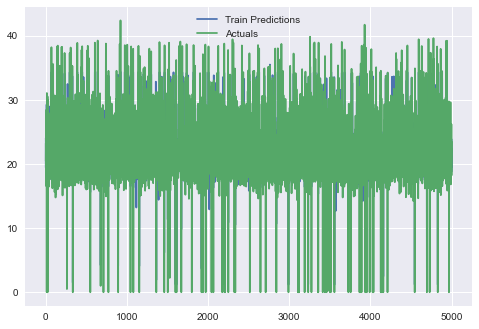

In [47]:
plt.plot(train_results['Train Predictions'][:5000],)
plt.plot(train_results['Actuals'][:5000])
plt.legend(['Train Predictions','Actuals'])